<a href="https://colab.research.google.com/github/rosshalpin/clip-guided-scene-arrangement/blob/main/DissertationProject_v0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'

!ln -s /content/drive/My\ Drive/Colab\ Notebooks/ $nb_path

sys.path.insert(0,nb_path)

!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/drive


In [2]:
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    import torch
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install --target=$nb_path fvcore iopath
        !pip install --target=$nb_path --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install --target=$nb_path 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2022-08-08 21:00:09--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2022-08-08 21:00:09 (35.1 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [4]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    AmbientLights,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [6]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = '/content/drive/My Drive/DissertationProject_v0.0/data'

In [7]:
device

device(type='cuda', index=0)

In [8]:
def load_mesh(input_path) -> Meshes:
  obj_filename = os.path.join(DATA_DIR, input_path)
  return load_objs_as_meshes([obj_filename], device=device)

In [9]:
fruit_mesh = load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
table_mesh = load_mesh(f"{DATA_DIR}/table_mesh/GenericClassicTable001.obj")

In [ ]:
# import numpy as np

# # Define the settings for rasterization and shading. Here we set the output image to be of size
# # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# # and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# # the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# # explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# # the difference between naive and coarse-to-fine rasterization. 
# raster_settings = RasterizationSettings(
#     image_size=512, 
#     blur_radius=0.0, 
#     faces_per_pixel=1,
#     bin_size=None
# )

# # Initialize a camera.
# # With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# # So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
# R, T = look_at_view_transform(8, 0, 180) 
# cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# # -z direction. 
# lights = PointLights(device=device, location=[[0.0, 0.0, -15.0]])


# # Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# # apply the Phong lighting model
# renderer = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         raster_settings=raster_settings
#     ),
#     shader=SoftPhongShader(
#         device=device
#     )
# )

# def render(batch_size, camera_dist, mesh):
#   num_cameras = int(batch_size/3)
#   meshes = mesh.extend(batch_size)

#   azim = np.linspace(-180, 180, num_cameras, endpoint=False)
#   elev_a = np.linspace(45, 45, num_cameras, endpoint=False)
#   elev_b = np.linspace(-45, -45, num_cameras, endpoint=False)
#   elev_c = np.linspace(0, 0, num_cameras, endpoint=False)

#   lights = AmbientLights(device=device)

#   Ra, Ta = look_at_view_transform(dist=camera_dist, azim=azim, elev=elev_a)
#   Rb, Tb = look_at_view_transform(dist=camera_dist, azim=azim, elev=elev_b)
#   Rc, Tc = look_at_view_transform(dist=camera_dist, azim=azim, elev=elev_c)

#   R = np.concatenate((Ra, Rb, Rc), axis=0)
#   T = np.concatenate((Ta, Tb, Tc), axis=0)

#   cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

#   images = renderer(meshes, cameras=cameras, lights=lights).cpu().numpy()

#   return images, num_cameras

# table_offset = table_mesh.verts_padded().new_tensor([0, 0, -1]).expand(table_mesh.verts_packed().shape)
# fruit_offset = fruit_mesh.verts_padded().new_tensor([0, 0, 0]).expand(fruit_mesh.verts_packed().shape)
# double_mesh = join_meshes_as_scene([fruit_mesh.clone().scale_verts(0.1).offset_verts_(fruit_offset), table_mesh.clone().scale_verts(3.5).offset_verts_(table_offset)])

# images, num_cameras = render(18,6, double_mesh)
# image_grid(images, rows=3, cols=num_cameras, rgb=True)

In [ ]:
# plot_batch_individually(fruit_mesh)

In [11]:
try:
  import clip
except ModuleNotFoundError:
  !pip install git+https://github.com/openai/CLIP.git
  import clip

In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 203MiB/s]


In [ ]:
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [13]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [14]:
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

In [15]:
class SceneObject():
    def __init__(self, mesh, scale=1):
      new_mesh = mesh.clone().scale_verts(scale)
      self._mesh = new_mesh
      self._scale = scale
      self._position = self._mesh_position()

    @property
    def mesh(self):
      return self._mesh

    @property
    def position(self):
      return self._position

    @position.setter
    def position(self, value):
      offset = [round(a-b,3) for a, b in zip(value, self._position)]
      self._set_position_helper(offset)

    def _mesh_position(self):
      return [round(float(((c.cpu()[0]+c.cpu()[1])/2)), 3) for c in self._mesh.get_bounding_boxes()[0]]

    def _set_position_helper(self, value):
      offset = self._mesh.verts_padded().new_tensor(value).expand(self._mesh.verts_packed().shape)
      self._mesh = self._mesh.offset_verts(offset)
      self._position = self._mesh_position()

    def translate(self, value):
      self._set_position_helper(value)


In [110]:
class Scene():
  def __init__(self, meshes: list):
    self.AZIM = torch.linspace(0, 180, 4)
    self.ELEV = [45]
    self.num_cameras = max(len(self.AZIM), len(self.ELEV))
    self._meshes = meshes
    self.CAMERA_DIST = 2.5
    self._scene = join_meshes_as_scene(meshes).extend(self.num_cameras)

  @property
  def scene(self):
    return self._scene

  @scene.setter
  def scene(self, value):
    self._scene = join_meshes_as_scene(value)

  @property
  def _lights(self):
    return AmbientLights(device=device)

  @property
  def _cameras(self):
    R, T = look_at_view_transform(dist=self.CAMERA_DIST, azim=self.AZIM, elev=self.ELEV)
    return FoVPerspectiveCameras(device=device, R=R, T=T)

  @property
  def renderer(self):
    return MeshRenderer(
        rasterizer=MeshRasterizer(
            raster_settings=RasterizationSettings(
              image_size=512, 
              faces_per_pixel=1,
              bin_size=None
            )
        ),
        shader=SoftPhongShader(
            device=device
        )
    )
  
  def render(self):
    return self.renderer(self.scene, cameras=self._cameras, lights=self._lights).cpu().numpy()


In [107]:
def clip_similarity(images: list, description: str):
  text_tokens = clip.tokenize([description]).cuda()
  images = map(preprocess, images)
  image_input =  torch.tensor(np.stack(images)).cuda()
  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

  return similarity[0]

In [18]:
from PIL import Image
def get_pil_image(input):
  return Image.fromarray((input * 255).astype('uint8'))

In [41]:
fruit_object = SceneObject(fruit_mesh, scale=0.04)

table_object = SceneObject(table_mesh)
table_object.position=[0,0,0]

In [55]:
test_objs = [fruit_object, table_object]
test_scene = Scene([a.mesh for a in test_objs])

In [56]:
images = test_scene.render()

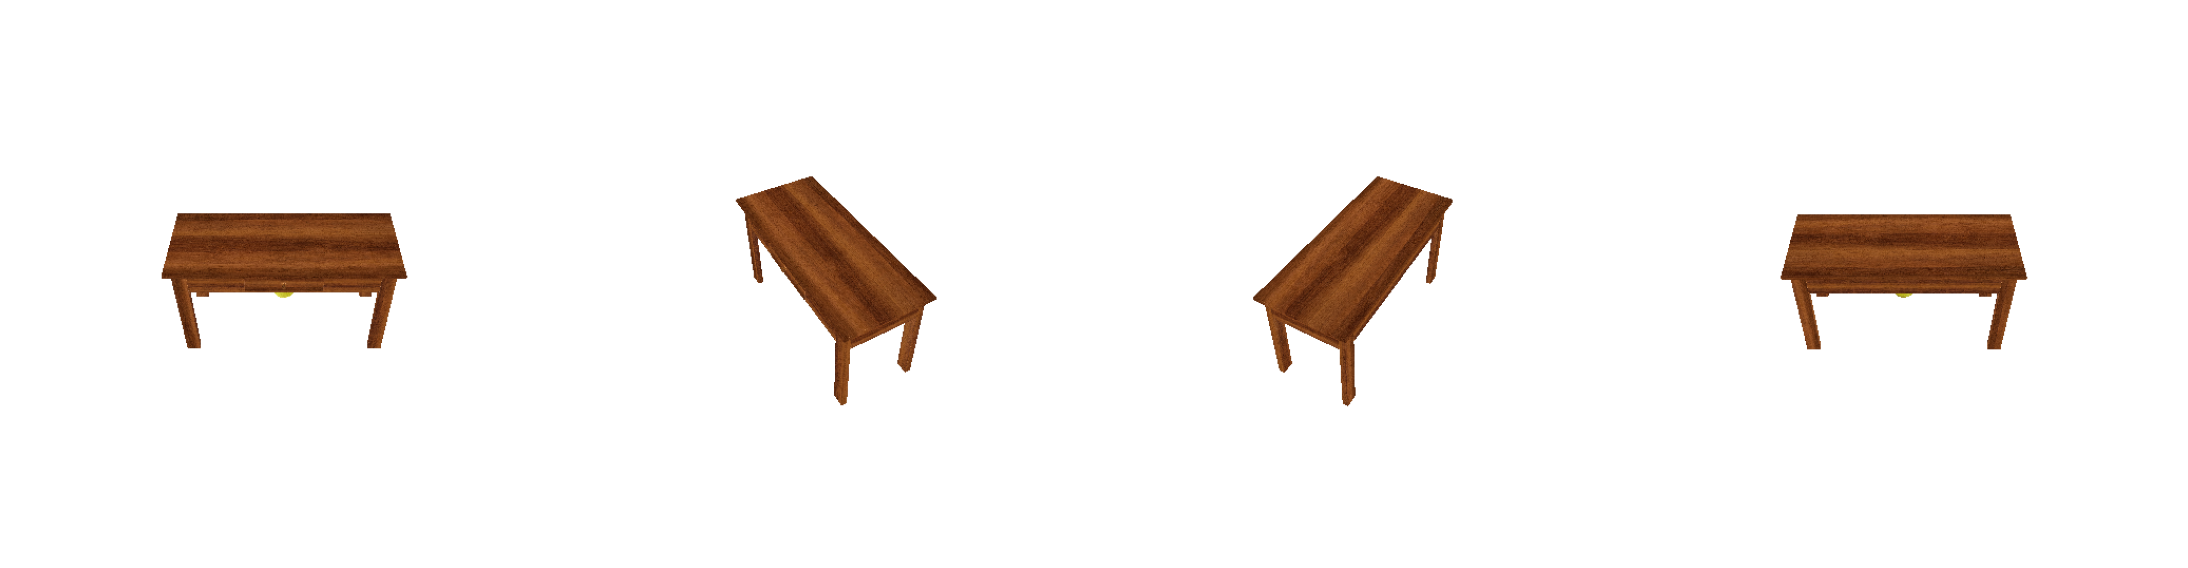

In [57]:
image_grid(images, rows=1, cols=test_scene.num_cameras, rgb=True)

In [175]:
from gym import Env
from gym.spaces import Box, Discrete, MultiDiscrete
import random
import copy

from scipy.stats import wilcoxon

class CustomTrain(Env):
  def __init__(self, objs, limit=None):
    self.action_space = Box(low=-0.1, high=0.1, shape=(3,))
    self.rounds = 0
    self.limit = limit
    self.reward = -1 
    self.GUIDE_STRING = "A piece of fruit placed on a wooden table"
    self.objs =  [copy.deepcopy(obj) for obj in objs]
    self.objs[0].position = self.action_space.sample()
    self.scene = Scene([a.mesh for a in self.objs])
    self.observation_space = Box(low=0, high=1, shape=(self.scene.num_cameras,))
    self.state = self.objs[0].position
    self.best_sim_matrix = np.zeros(self.scene.num_cameras).astype(np.float32)
    self.images = None
    self.stuck_counter = 0
    self.limit_box = [[-1,-1,-1],[1,1,1]]
    self.best = {}

  def get_similarity(self):
    self.scene = Scene([a.mesh for a in self.objs])
    images = self.scene.render()
    pil_images = [get_pil_image(img[..., :3]) for img in images]
    self.images = images
    return clip_similarity(pil_images, self.GUIDE_STRING)

  def limit_action(self, action, obj):
    translation_result = [a+b for a,b in zip (obj.position, action)]
    for i, val in enumerate(translation_result):
        if val < self.limit_box[0][i]:
            action[i] = 0
        elif val > self.limit_box[1][i]:
            action[i] = 0
    return action
  
  def step(self, action):
    info = {}
    done = False
    rw = 0
    self.rounds += 1

    initial_position = copy.deepcopy(self.objs[0].position)

    # action_a = self.limit_action(action[:3], self.objs[0])
    # action_b = self.limit_action(action[3:], self.objs[1])
    # self.objs[1].translate(action_b)

    self.objs[0].translate(action)
    
    self.scene = [a.mesh for a in self.objs]

    obs = np.asarray(self.get_similarity()).astype(np.float32)

    print(obs, self.best_sim_matrix)

    stat, p = wilcoxon(obs, self.best_sim_matrix, alternative='greater')

    if p < 0.07:
      self.best_sim_matrix = obs
      self.best["images"] = self.images
      rw = 1
    elif p > 0.07:
      # self.objs[0].position = initial_position
      rw = -1

    self.reward += rw
    
    if self.rounds > self.limit:
      done = True

    info["obj"] = self.objs
    info["images"] = self.images
    info["best"] = self.best

    return obs, self.reward, done, info
  
  def reset(self):
    self.state = np.array([0,0,0])
    return np.array([0]).astype(np.float32)

  def render(self, mode):
    pass
    # print(f"Round : {self.rounds}\nCLIP Score : {similarity} \nReward Received: {rw}")
    # print(f"Total Reward : {self.collected_reward}")

In [177]:
env = CustomTrain([fruit_object, table_object], limit=10)
done = False
images = []
best = None
while not done:
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  images.append(info["images"])
  best = info["best"]["images"]

[0.2948922  0.28225827 0.2821073  0.31087598] [0. 0. 0. 0.]
[0.29697663 0.28225827 0.28231567 0.31432515] [0.2948922  0.28225827 0.2821073  0.31087598]


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


[0.2904378  0.28765988 0.2821073  0.30352968] [0.29697663 0.28225827 0.28231567 0.31432515]
[0.29760832 0.28572896 0.28563294 0.3105667 ] [0.29697663 0.28225827 0.28231567 0.31432515]
[0.30797482 0.28931475 0.28229606 0.30917972] [0.29697663 0.28225827 0.28231567 0.31432515]
[0.3019982  0.3143044  0.2821073  0.28452745] [0.29697663 0.28225827 0.28231567 0.31432515]
[0.30475798 0.31263247 0.2821073  0.28631416] [0.29697663 0.28225827 0.28231567 0.31432515]
[0.30847508 0.28580627 0.2821073  0.28671327] [0.29697663 0.28225827 0.28231567 0.31432515]
[0.28109407 0.28319183 0.2832745  0.3125823 ] [0.29697663 0.28225827 0.28231567 0.31432515]
[0.3035535  0.28215617 0.2834647  0.32068273] [0.29697663 0.28225827 0.28231567 0.31432515]
[0.3137991  0.2879172  0.2821073  0.30263197] [0.29697663 0.28225827 0.28231567 0.31432515]


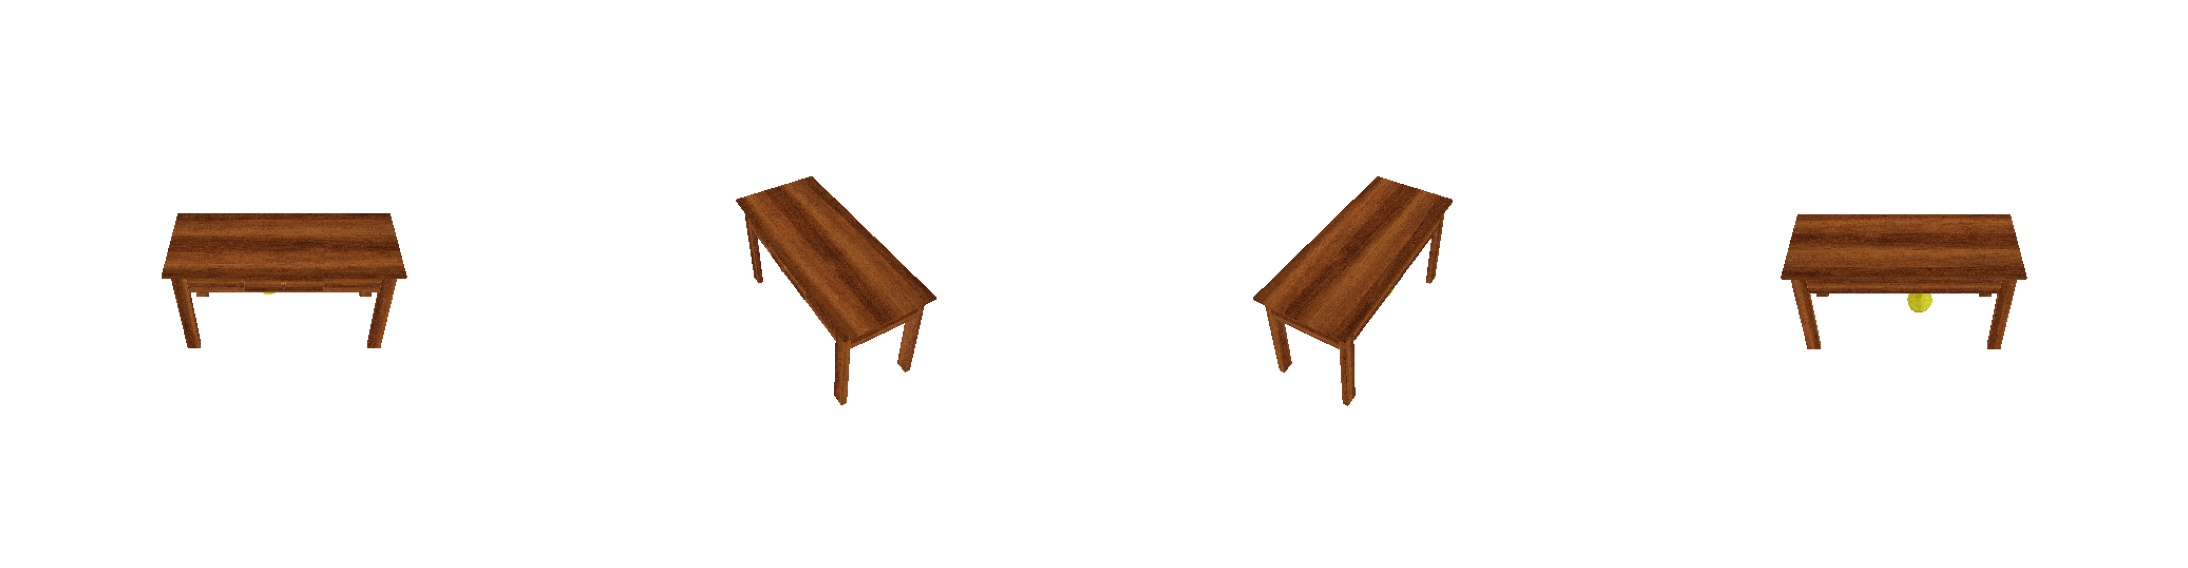

In [148]:
image_grid(best, rows=1, cols=test_scene.num_cameras, rgb=True)

In [173]:
my_pil = [get_pil_image(img[..., :3]) for img in best]

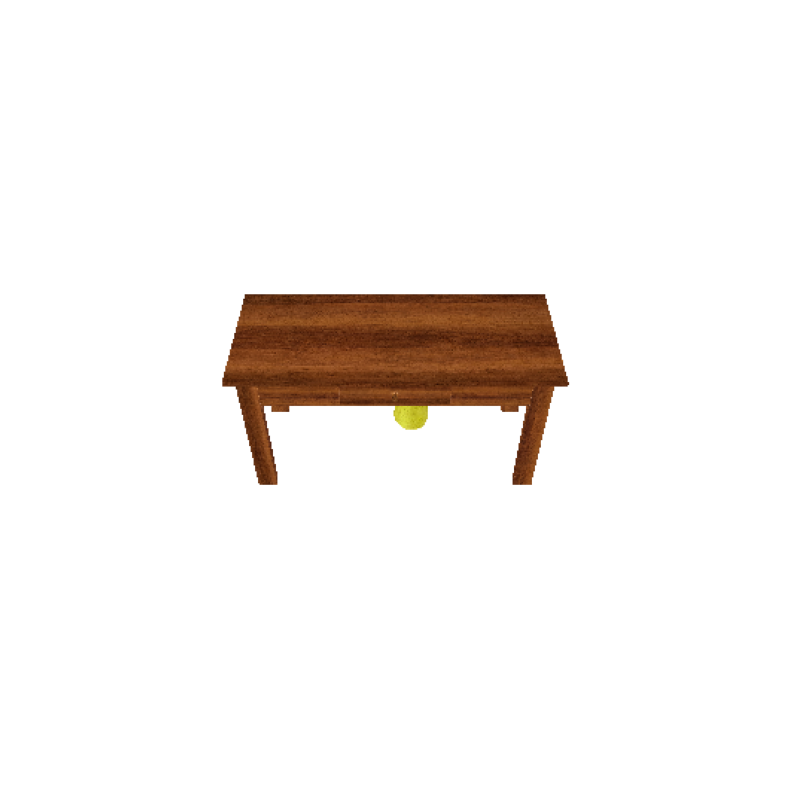

In [162]:
plt.figure(figsize=(7, 7))
plt.imshow(best[0, ..., :3])
plt.grid("off");
plt.axis("off");

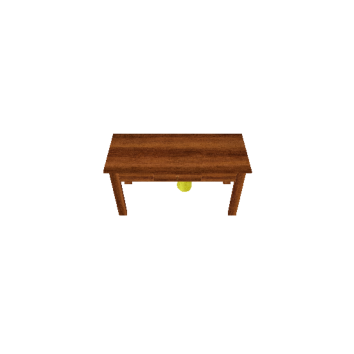

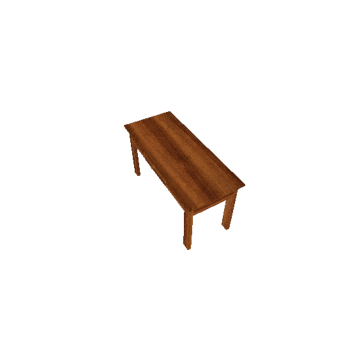

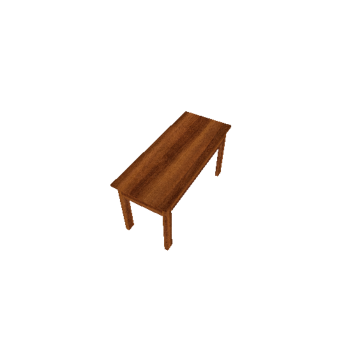

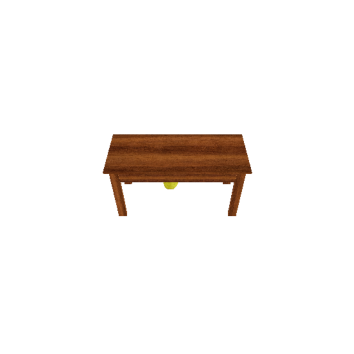

In [174]:
for img in my_pil:
  plt.figure(figsize=(3, 3))
  plt.imshow(img)
  plt.grid("off");
  plt.axis("off");

In [ ]:
try:
  import stable_baselines3
except ModuleNotFoundError:
  !pip install stable-baselines3[extra]
  import stable_baselines3

In [ ]:
env = CustomTrain([fruit_object, table_object])

In [ ]:
from stable_baselines3.common.env_checker import check_env


check_env(env, warn=True)

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/env_checker.py:273: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [ ]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env

env = make_vec_env(lambda: env, n_envs=4)

In [ ]:
train_model = PPO('MlpPolicy', env, verbose=1).learn(10000)

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 14   |
|    iterations      | 1    |
|    time_elapsed    | 569  |
|    total_timesteps | 8192 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 14            |
|    iterations           | 2             |
|    time_elapsed         | 1151          |
|    total_timesteps      | 16384         |
| train/                  |               |
|    approx_kl            | 2.7594433e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 3.54e+09      |
|    n_updates            | 10            |
|    policy_gradient_loss | -4.05e-05     |
|    std                  | 1             |
|    value_loss         

In [ ]:
# Test the trained agent
obs = env.reset()
n_steps = 3
best_objs = None
best = None
for step in range(n_steps):
  action, _ = train_model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  # print("Action: ", action)
  obs, reward, done, info = env.step(action)
  # print('obs=', obs, 'reward=', reward, 'done=', done)
  best = info[0]["best"]
  best_objs = info[0]["obj"]
  

Step 1
Step 2
Step 3


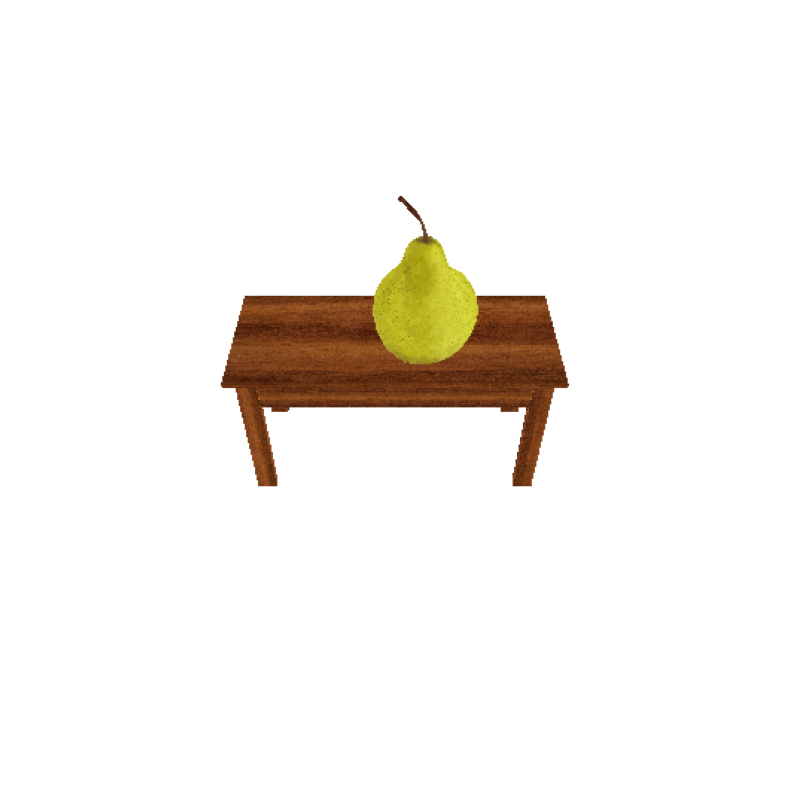

In [ ]:
plt.figure(figsize=(7, 7))
plt.imshow(best["image"])
plt.grid("off");
plt.axis("off");

In [ ]:
_scene = join_meshes_as_scene([best_objs[0].mesh, best_objs[1].mesh])

plot_batch_individually(_scene)

In [98]:
from scipy.stats import ranksums, wilcoxon

stat, p = wilcoxon([0.34,0.36,0.29,0.20], [0.28,0.31,0.21,0.20], alternative='greater')

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [99]:
p

0.05440471502027284

In [66]:
res.statistic, res.pvalue

(6.0, 0.05440471502027284)